FIIT STU v Bratislave, ZS 2019/2020, Utorok 11:00

---

# Projekt z predmetu Inteligentná analýza údajov
### Michal Heban, Ivana Frankovičová
Datasety č. 10

---

## 3. fáza - Strojové učenie

In [235]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb;
import sklearn.metrics as sm

## Predspracovanie nových datasetov

Načítame si upravený dataset s trénovacími dátami, csv súbor s natrénovanými dátami, ktoré sme si ukladali v druhej fáze a nové datasety s validačnými a testovacími dátami, ktoré spojíme a upravíme.

In [99]:
train_dataset = pd.read_csv("merged_train.csv", lineterminator='#')

In [116]:
datasetProcessValues = pd.read_csv("trainingPreprocessData.csv", lineterminator='#')

In [82]:
other_valid = pd.read_csv("other_valid.csv", sep=',', index_col = 0)

In [4]:
personal_valid = pd.read_csv("personal_valid.csv", sep=',', index_col = 0)

In [394]:
other_test = pd.read_csv("other_test.csv", sep=',', index_col = 0)

In [395]:
personal_test = pd.read_csv("personal_test.csv", sep=',', index_col = 0)

Pridali sme funkcie na úpravu kategorických atribútov na numerické:

In [391]:
sex_to_numeric = {
    "Male":0,
    "Female":1
}
pregnant_to_numeric = {
    "f":0,
    "t":1
}
def changePregnantToCategorical(dataset):
    dataset['pregnant'] = [pregnant_to_numeric[item] for item in dataset['pregnant']]
def changeSexToCategorical(dataset):
    dataset['sex'] = [sex_to_numeric[item] for item in dataset['sex']]

In [392]:
def categoricalToNumber(dataset):
    changePregnantToCategorical(dataset)
    changeSexToCategorical(dataset)

In [393]:
categoricalToNumber(train_dataset)

KeyError: 0

 Nakopírovali sme si sem všetky funkcie z druhej fázy, ktoré budeme potrebovať na úpravu datasetov. Vo funkciách sme museli pridať kód na úpravu niektorých atribútov, ktoré obsahovali nullové hodnoty. Tieto atribúty nemali v trénovacom datasete nullové hodnoty a preto sme ich v druhej fáze neriešili.

In [58]:
def dateFormat(date):
    dateForm = date.replace('1', '0')
    dateForm = dateForm.replace('2', '0')
    dateForm = dateForm.replace('3', '0')
    dateForm = dateForm.replace('4', '0')
    dateForm = dateForm.replace('5', '0')
    dateForm = dateForm.replace('6', '0')
    dateForm = dateForm.replace('7', '0')
    dateForm = dateForm.replace('8', '0')
    dateForm = dateForm.replace('9', '0')
    return dateForm

In [59]:
def changeDate(date):
    datef = dateFormat(date)
    if(datef == '00-00-00'):
        day = date[6:]
        month = date[:5]
        month = month[3:]
        year = date[:2]
        firstOfYear = year[:1]
        if(firstOfYear == '1' or firstOfYear == '0'):
            year ='20'+year
        else:
            year ='19'+year
        date = year
        date = date+'-'
        date = date+month
        date = date+'-'
        date = date+day
        return date
    if(datef == '0000-00-00 00:00:00'):
        date = date[:10]
        return date
    if(datef == '00/00/0000'):
        day = date[:2]
        month = date[:5]
        month = month[3:]
        year = date[6:]
        date = year
        date = date+'-'
        date = date+month
        date = date+'-'
        date = date+day
        return date
    if(datef == '0000/00/00'):
        date = date.replace('/','-')
        return date
    if(datef == '0000-00-00 00 00 00'):
        date = date[:10]
        return date
    if(datef == '0000-00-00'):
        return date
    else:
        print('no match')
        return date

In [60]:
def changePregnantInfoFlag(flag):
    if(flag == 'F'):
        return 'f'
    if(flag == 'FALSE'):
        return 'f'
    if(flag == 'T'):
        return 't'
    if(flag == 'TRUE'):
        flag = 't'
    if(flag == 't'):
        return 't'
    if(flag == 'f'):
        return 'f'

In [61]:
def addressCorrection(address):
    address = address.replace('\r\n',' ')
    return address

In [62]:
def process_pi(text):
    if pd.isnull(text) or "undefined" in text:
        return pd.Series(["undefined"]*5)
    splitted_pi = re.split('[| \r\r\n]',text)
    splitted_pi = list(filter(None,splitted_pi))
    splitted_pi.remove("--")
    return pd.Series([splitted_pi[0],splitted_pi[1],splitted_pi[2],splitted_pi[3],splitted_pi[4]])

In [63]:
def fixSex(sex):
    sex = sex.replace(' ','')
    return sex

In [127]:
def setMissingValuesToMean(dataset,column):
    imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
    imp_mean = imp_mean.fit(train_dataset[[column]])
    dataset[column] = imp_mean.transform(dataset[[column]]).ravel()

In [126]:
def setMissingValuesToMedian(dataset,column):
    imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
    imp_mean = imp_mean.fit(train_dataset[[column]])
    dataset[column] = imp_mean.transform(dataset[[column]]).ravel()

In [419]:
def setMissingValuesToSegmentMean(dataset,column):
    meanMale = train_dataset[train_dataset['sex'] == 0][column].mean()
    meanFemale = train_dataset[train_dataset['sex'] == 1][column].mean()
    dataset.loc[(dataset[column].isnull()) & (dataset['sex'] == 'Male'), column] = meanMale
    dataset.loc[(dataset[column].isnull()) & (dataset['sex'] == 'Female') , column] = meanFemale

In [396]:
def setMissingValueToUndefined(dataset,column):
    dataset.loc[dataset[column].isna() , column] = 'undefined'
    dataset.loc[dataset[column] == '??',column] = 'undefined'
    dataset.loc[dataset[column] == '?',column] = 'undefined'

In [68]:
def repair_age(age):
    if pd.isnull(age):
        return pd.Series(np.nan)
    if age >= 130:
        return int(age / 100)
    if age < 0:
        return int(((age * -1) / 100))
    else:
        return int(age)

In [123]:
def getMinFromDataset(dataset,column):
    min = dataset[column].min()
    return float(min)

In [343]:
def method3(dataset,column):
    minimumValue = datasetProcessValues[column][0]
    if minimumValue < 0:
        minimumValueForLogShift = (minimumValue * -1) + 0.5
        dataset[column] = dataset[column] + minimumValueForLogShift
    dataset.dropna(subset=[column], inplace=True)
    dataset[column] = np.log(dataset[column])

In [121]:
def method1(dataset,column,minV,maxV):
    upperQ = datasetProcessValues[column][4]
    dataset.loc[dataset[column] > maxV, column] = upperQ
    
    lowerQ = datasetProcessValues[column][5]
    dataset.loc[dataset[column] < minV, column] = upperQ
    

In [72]:
def mergeDatasets(dataset1,dataset2):
    mergedDataset = pd.merge(dataset1,dataset2, on=['name','address'], how='left')
    duplicates = mergedDataset[mergedDataset.duplicated(['name', 'address','age'], keep=False)].sort_values(by = 'name')
    mergedDataset = mergedDataset.drop_duplicates(['name', 'address'], keep=False)
    names = duplicates.name.unique()

    for name in names:
        tmp = duplicates[duplicates['name'] == name]
        tmp = tmp.fillna(method='ffill')
        tmp = tmp.fillna(method='bfill')
        tmp = tmp.drop_duplicates(['name'])
        mergedDataset = mergedDataset.append(tmp, ignore_index=True)
    return mergedDataset

In [73]:
def dataFixing(dataset):
    dataset['date_of_birth'] = dataset['date_of_birth'].apply(changeDate)
    dataset['pregnant'] = dataset['pregnant'].apply(changePregnantInfoFlag)
    dataset['address'] = dataset['address'].apply(addressCorrection)
    dataset[['job','state','family_status','home','color']] = dataset['personal_info'].apply(process_pi)
    del dataset['personal_info']
    dataset['sex'] = dataset['sex'].apply(fixSex)
    dataset.loc[(dataset["sex"] == 'Male') & (dataset["pregnant"] == 't') , 'pregnant'] = 'f'
    dataset['capital'] = dataset['capital-gain'] - dataset['capital-loss']
    dataset['age'] = dataset['age'].apply(repair_age)
    del dataset["capital-gain"]
    del dataset["capital-loss"]

In [401]:
def missingDataProcessing(dataset):
    setMissingValuesToMean(dataset,'kurtosis_oxygen')
    setMissingValuesToMean(dataset,'hours-per-week')
    setMissingValuesToMean(dataset,'std_glucose')
    setMissingValuesToMean(dataset,'skewness_glucose')
    setMissingValuesToSegmentMean(dataset,'mean_glucose')
    setMissingValuesToMean(dataset,'kurtosis_glucose')
    setMissingValuesToMedian(dataset,'fnlwgt')
    setMissingValueToUndefined(dataset,'income')
    setMissingValueToUndefined(dataset,'capital')
    setMissingValueToUndefined(dataset,'job')
    setMissingValueToUndefined(dataset,'state')
    setMissingValueToUndefined(dataset,'home')
    setMissingValueToUndefined(dataset,'education') # TODO if enough time set due to education num
    setMissingValueToUndefined(dataset,'relationship')
    setMissingValueToUndefined(dataset,'education-num') # TODO if enough time set due to education

In [75]:
def outlierProcessing(dataset):
    method1(dataset,'kurtosis_glucose',datasetProcessValues['kurtosis_glucose'][1],datasetProcessValues['kurtosis_glucose'][2])
    method1(dataset,'kurtosis_oxygen',datasetProcessValues['kurtosis_oxygen'][1],datasetProcessValues['kurtosis_oxygen'][2])
    method1(dataset,'mean_glucose',datasetProcessValues['mean_glucose'][1],datasetProcessValues['mean_glucose'][2])    
    method3(dataset,'mean_oxygen')
    method3(dataset,'skewness_glucose')
    method3(dataset,'skewness_oxygen')
    method1(dataset,'std_glucose',datasetProcessValues['std_glucose'][1],datasetProcessValues['std_glucose'][2])
    method1(dataset,'std_oxygen',datasetProcessValues['std_oxygen'][1],datasetProcessValues['std_oxygen'][2])

In [341]:
def finalFunction(dataset1,dataset2):
    mergedDataset = mergeDatasets(dataset1,dataset2)
    dataFixing(mergedDataset)
    missingDataProcessing(mergedDataset)
    outlierProcessing(mergedDataset)
    return mergedDataset

Funkcie máme nakopírované, môžeme upravovať datasety. Upravíme validačné datasety a testovacie datasety.

In [422]:
valid = finalFunction(personal_valid, other_valid)

C:\Users\Nay\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [423]:
valid.isna().sum()

name                0
address             0
age                 0
sex                 0
date_of_birth       0
kurtosis_oxygen     0
pregnant            0
education-num       0
relationship        0
skewness_glucose    0
mean_glucose        0
std_oxygen          0
skewness_oxygen     0
kurtosis_glucose    0
education           0
fnlwgt              0
class               0
std_glucose         0
income              0
mean_oxygen         0
hours-per-week      0
job                 0
state               0
family_status       0
home                0
color               0
capital             0
dtype: int64

In [420]:
test_dataset = finalFunction(personal_test, other_test)

In [421]:
test_dataset.isna().sum()

name                0
address             0
age                 0
sex                 0
date_of_birth       0
education-num       0
std_oxygen          0
fnlwgt              0
relationship        0
kurtosis_glucose    0
skewness_oxygen     0
income              0
mean_oxygen         0
pregnant            0
std_glucose         0
kurtosis_oxygen     0
skewness_glucose    0
mean_glucose        0
education           0
hours-per-week      0
job                 0
state               0
family_status       0
home                0
color               0
capital             0
dtype: int64

Po úprave vidíme, že datasety sú spojené a nenachádzajú sa v nich už žiadne nullové hodnoty.

## Rozhodovacie pravidlá pre klasifikáciu - manuálne

Pre tvorbu rozhodovacích pravidiel pre klasifikáciu sme si vybrali atribúty mean_glucose a mean_oxygen. Vytvorili sme funkcie, ktoré predikujú, či človek má cukrovku podľa zvýšených, resp. znížených hodnôt cukru a kyslíka v krvi:

In [300]:
def predictionDiabetesFromGlucose(dataset):
    dataset.loc[dataset['mean_glucose'] < diabetesGlucoseThreshold, 'predicted'] = 1
    dataset.loc[dataset['mean_glucose'] >= diabetesGlucoseThreshold, 'predicted'] = 0

In [306]:
def predictionDiabetesFromOxygen(dataset):
    dataset.loc[dataset['mean_oxygen'] < diabetesOxygenThreshold, 'predicted'] = 0
    dataset.loc[dataset['mean_oxygen'] >= diabetesOxygenThreshold, 'predicted'] = 1

Nasledujúca funkcia slúži na výpis hodnôt accuracy, precision a recall:

In [293]:
def scoresOfPredictions(dataset,predictionDataset,typeOfData):
    name = 'validačný'
    if(typeOfData == 1):
        name = 'trénovací'
    labels = dataset['class'].values
    print('Výsledky pre '+name+' dataset')
    print("   * Accuracy score:",sm.accuracy_score(labels,predictionDataset['predicted']))
    print("   * Precision score:",sm.precision_score(labels,predictionDataset['predicted'], average='macro'))
    print("   * Recall score:",sm.recall_score(labels,predictionDataset['predicted'], average='macro'))

### mean_glucose

In [175]:
gpd = valid.loc[valid['class'] == 1,'mean_glucose']
gnd = valid.loc[valid['class'] == 0,'mean_glucose']

(Poznámka: gpd - glucose positive diabetes, gnd - glucose negative diabetes)

Vykreslili sme si histogramy mean_glucose. Červenou farbou sú vyznačené hodnoty cukru v krvi u ľudí, ktorí majú cukrovku. Modrou farbou sú vyznačené hodnoty cukru v krvi u ľudí, ktorí cukrovku nemajú.

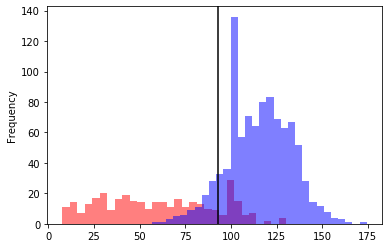

In [347]:
gpd.plot.hist(bins=30,color = 'red',alpha = 0.5)
gnd.plot.hist(bins = 30, color = 'blue',alpha = 0.5)
plt.axvline(x=93, color = 'black')
diabetesGlucoseThreshold = 93

Ako predikčnú hodnotu sme si vzali číslo 93. Vyznačili sme ho do grafu čiarou pre vizuálne rozlíšenie. 

In [276]:
predictedTrainG = train_dataset[['class','mean_glucose']].copy()
predictedValidG = valid[['class','mean_glucose']].copy()
predictedTrainG['predicted'] = 0
predictedValidG['predicted'] = 0

In [348]:
predictionDiabetesFromGlucose(predictedTrainG)
predictionDiabetesFromGlucose(predictedValidG)

Predikovali sme cukrovku u ľudí v trénovacom aj validačnom datasete. Skóre accuracy, precision a recall nám vyšli relatívne vysoké, ak teda vezmeme do úvahy, že sme použili iba jedno veľmi jednoduché pravidlo.

In [349]:
scoresOfPredictions(train_dataset,predictedTrainG,1)

Výsledky pre trénovací dataset
   * Accuracy score: 0.8759216882786677
   * Precision score: 0.8350719298771052
   * Recall score: 0.8423977357895152


In [305]:
scoresOfPredictions(valid,predictedValidG,0)

Výsledky pre validačný dataset
   * Accuracy score: 0.8771929824561403
   * Precision score: 0.8387145495658779
   * Recall score: 0.8526206235586571


### mean_oxygen

In [350]:
opd = valid.loc[valid['class'] == 1,'mean_oxygen']
ond = valid.loc[valid['class'] == 0,'mean_oxygen']

(Poznámka: opd - oxygen positive diabetes, ond - oxygen negative diabetes)

Vykreslili sme si histogramy mean_oxygen. Červenou farbou sú vyznačené hodnoty kyslíka v krvi u ľudí, ktorí majú cukrovku. Modrou farbou sú vyznačené hodnoty kyslíka v krvi u ľudí, ktorí cukrovku nemajú.

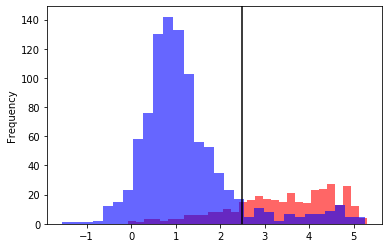

In [353]:
opd.plot.hist(bins=30,color = 'red',alpha = 0.6)
ond.plot.hist(bins = 30, color = 'blue',alpha = 0.6)
plt.axvline(x=2.5, color = 'black')
diabetesOxygenThreshold = 2.5

Ako predikčnú hodnotu sme si vzali číslo 2,5. Vyznačili sme ho do grafu čiarou pre vizuálne rozlíšenie. 

In [354]:
predictedTrainO = train_dataset[['class','mean_oxygen']].copy()
predictedValidO = valid[['class','mean_oxygen']].copy()
predictedTrainO['predicted'] = 0
predictedValidO['predicted'] = 0

In [355]:
predictionDiabetesFromOxygen(predictedTrainO)
predictionDiabetesFromOxygen(predictedValidO)

Predikovali sme cukrovku u ľudí v trénovacom aj validačnom datasete. Skóre accuracy, precision a recall nám, rovnako ako pri mean_glucose, vyšli opäť celkom vysoké. 

In [356]:
scoresOfPredictions(train_dataset,predictedTrainO,1)

Výsledky pre trénovací dataset
   * Accuracy score: 0.8728705822527333
   * Precision score: 0.8330405727923628
   * Recall score: 0.832166724022313


In [357]:
scoresOfPredictions(valid,predictedValidO,0)

Výsledky pre validačný dataset
   * Accuracy score: 0.8756674294431731
   * Precision score: 0.8377839335180055
   * Recall score: 0.8469495941777232


In [ ]:
# TODO opýtať sa čo asi spojiť či môžne spojiť tieto dva čo boli robené samostatne

## Rozhodovací strom

In [293]:
def scoresOfTreePredictions(dataset,predictionDataset,typeOfData):
    name = 'validačný'
    if(typeOfData == 1):
        name = 'trénovací'
    labels = dataset['class'].values
    print('Výsledky pre '+name+' dataset')
    print("   * Accuracy score:",sm.accuracy_score(labels,predictionDataset['predicted']))
    print("   * Precision score:",sm.precision_score(labels,predictionDataset['predicted'], average='macro'))
    print("   * Recall score:",sm.recall_score(labels,predictionDataset['predicted'], average='macro'))
    print("   * F1 score:",sm.f1_score(labels,predictionDataset['predicted'], average='macro'))

In [ ]:
#mergedTrain = pd.read_csv('./merged_train.csv', index_col=0)
#mergedValid = pd.read_csv('./merged_valid.csv', index_col=0)

labelsTrain = train_dataset['class_type'].values
featuresTrain = train_dataset[col2] # neviem co dat namiesto col2

labelsValid = valid['class_type'].values
featuresValid = valid[col2] # ani tu neviem co dat namiesto col2

clf = DecisionTreeClassifier(criterion='entropy',max_depth = 4,class_weight = {0:50,1:30,2:20})
model = clf.fit(featuresTrain, labelsTrain)

test = featuresValid
predicted = clf.predict(test)


In [ ]:
scoresOfTreePredictions(valid, predicted, 0)